# Jester data exercise

This file is created as part of requirements in CE888.<br>
**Author** : Tomoko Ayakawa<br>
**Created on**: 4 February 2019<br>
**Last modified**: 13 February 2019

## (1) Import libraries

In [205]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
np.set_printoptions(precision = 3)

## (2) Load data

In [2]:
joke_rating_df = pd.read_csv("jester-data-1.csv", header=None, index_col=0)
joke_rating_df.head(5)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


#### Prepare trainig, validation and test datasets

In [3]:
num_users = joke_rating_df.shape[0]
num_jokes = joke_rating_df.shape[1]

In [4]:
# obtain index of cells which are not 99
trg_idx=[]
tst_idx=[]
for i in range (num_users):
    for j in range (num_jokes):
        if joke_rating_df.values[i][j] != 99:
            trg_idx.append ([i,j])
        else:
            tst_idx.append ([i,j])

#### Split the data into training and validation datasets

In [169]:
# shuffule the list of target index
np.random.shuffle(trg_idx)

num_trg_idx = len (trg_idx)
split = num_trg_idx//10
from sklearn.model_selection import train_test_split
trg_idx, vld_idx = train_test_split(trg_idx, test_size=0.2)
vld_idx, vld_tst_idx = train_test_split(vld_idx, test_size=0.5)    
#vld_idx = trg_idx[:split]
#trg_idx = trg_idx[split:]

print ("Training: %d, Validation: %d, Test: %d, Latent (99s): %d" % \
       (len(trg_idx), len(vld_idx), len(vld_tst_idx), len(tst_idx)))

Training: 345982, Validation: 43248, Test: 43248, Latent (99s): 687845


## (3) Latent factor modelling
#### Set random latent factors for users and jokes

In [226]:
n_factors = 3

latent_user_factors = np.random.random((num_users, n_factors))
latent_joke_factors = np.random.random((num_jokes,n_factors))

#### Predict rating
Compute the rating by computing dot product of `latent user factor` and `latent joke factor`.

In [227]:
def predict_rating(user_id,joke_id):
    user_factor = latent_user_factors[user_id]
    joke_factor = latent_joke_factors[joke_id]

    return user_factor.dot(joke_factor)

#### Train the model
1. Compute the rating with current latent factors
2. Update the latent factors proportionally to the error

Argument: `alpha` = learning model (default 0.0001)

In [228]:
def train(user_id, joke_id, rating, mode, alpha = 0.0001):
    pred_rating = predict_rating(user_id, joke_id)
    err = pred_rating - rating
    
    # update latent factors when mode = 0 (training)
    if mode == 0:
        user_factor_values = latent_user_factors[user_id][:]
        latent_user_factors[user_id] -= alpha * err * latent_joke_factors[joke_id]
        latent_joke_factors[joke_id] -= alpha * err * user_factor_values
    
    return err

#### Store the errors

In [229]:
def compute_error(indices, mode):
    errors = []
    for i in indices:
        user_id, joke_id = i[0], i[1]
        rating = joke_rating_np[user_id][joke_id]
        if (not np.isnan (rating)):
            err = train (user_id, joke_id, rating, mode)
            errors.append (err)
    
    return errors

#### Training iteration
Iterate training for `iterations` times.<br>
Ratio of Training:Validation:Test = 0.8:0.1:0.1.

In [230]:
joke_rating_np = joke_rating_df.values

def sgd(iterations = 300000):
    minMSE, minMSEIte = 0, -1
    trgMSEs, vldMSEs = [], []
    
    
    for i in range(iterations):
        # training
        trg_error = compute_error (trg_idx, 0)
        trg_mse = (np.array(trg_error) ** 2).mean() 
        trgMSEs.append(trg_mse)
        
        # validation
        vld_error = compute_error (vld_idx, 1)
        vld_mse = (np.array(vld_error) ** 2).mean()   
        if ((minMSEIte==-1) or (minMSE>vld_mse) ):
            minMSE=vld_mse
            minMSEIte=i
        vldMSEs.append(vld_mse)

        if(i%100 == 0 ):
            print ("@iteration %6d: Training MSE = %.5f | Validation MSE = %.5f"\
                    % (i, trg_mse, vld_mse))
    print ("\nMinimum validation MSE is %f at iteration %d" % (minMSE, minMSEIte))
    
    return trgMSEs, vldMSEs

In [231]:
# lowest validation MSE and test MSE after 200 iterations
## n_factors=1, alpha = 0.0001, MSE = @iteration (Test MSE )
## n_factors=2, alpha = 0.0001, MSE = 18.928472 @iteration 135 (Test MSE 19.31212)
## n_factors=3, alpha = 0.0001, MSE = 18.872904 @iteration 124 (Test MSE 19.38781)
## n_factors=4, alpha = 0.0001, MSE = 18.868014 @iteration 114 (Test MSE 19.58481)
## n_factors=5, alpha = 0.0001, MSE = 18.880447 @iteration 112 (Test MSE 19.70796)
## n_factors=6, alpha = 0.0001, MSE = 17.132327 @iteration 140 (Test MSE 17.36022)
## n_factors=7, alpha = 0.0001, MSE = 17.150975 @iteration 142 (Test MSE 17.12852)
## n_factors=8, alpha = 0.0001, MSE = 18.943137 @iteration 96 (Test MSE 20.75772)
## n_factors=9, alpha = 0.0001, MSE = 18.927403 @iteration 96 (Test MSE 20.85837)
## n_factors=10, alpha = 0.0001, MSE = 17.174647 @iteration 117 (Test MSE 17.51095)
## with 0.001, unknown error occured twice and Null value was returned as MSE

trgMSEs, vldMSEs = sgd (200)

@iteration      0: Training MSE = 27.00644 | Validation MSE = 26.46796
@iteration    100: Training MSE = 19.51137 | Validation MSE = 21.93953

Minimum validation MSE is 20.052380 at iteration 155


#### Test the model

In [232]:
vld_tst_error = compute_error (vld_tst_idx, 1)
vld_tst_mse = (np.array(vld_tst_error) ** 2).mean()   

print ("Test MSE = %.5f" % vld_tst_mse)

Test MSE = 20.50282


#### Plot the MSE

In [234]:
vld_tst_mse

20.502818413961535

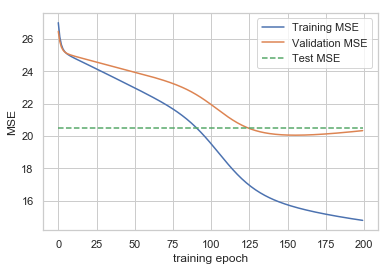

In [237]:
sns.set()
sns.set_style('whitegrid')

x=range(len(trgMSEs))
testMSEs=[vld_tst_mse]*len(trgMSEs)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, trgMSEs, label="Training MSE")
ax.plot(x, vldMSEs, label="Validation MSE")
ax.plot(x, testMSEs, label="Test MSE", linestyle="dashed")
ax.set_xlabel("training epoch")
ax.set_ylabel("MSE")
ax.legend()
plt.show()

plt.savefig("MSE_per_training_epoch.png", bbox_inches='tight')

## (4) The best and the worst rated jokes

In [238]:
import read_jokes as RJ
jokes_list = RJ.get_jokes()

In [239]:
# fill test data (99) with predicted values
joke_rating_copy_np = joke_rating_np
for i in tst_idx:
    user_id, joke_id = i[0], i[1]
    pred_rating = predict_rating(user_id, joke_id)
    joke_rating_copy_np[user_id][joke_id] = pred_rating
joke_rating_copy_df = pd.DataFrame(joke_rating_copy_np)

In [240]:
# mean score of each joke
mean = joke_rating_copy_df.mean()

# best score and its column index
best = mean.max()
best_idx = mean.idxmax()

# worst score and its column index
worst = mean.min()
worst_idx = mean.idxmin()

BLUE = "\033[34m"
RESET = "\033[0m"
print ("Best rated joke: index %d, mean rate %f\n" \
       "%s%s%s" % (best_idx, best, BLUE, jokes_list[best_idx], RESET))
print ("Worst rated joke: index %d,mean rate %f\n" \
       "%s%s%s" % (worst_idx, worst, BLUE, jokes_list[worst_idx], RESET))

Best rated joke: index 49, mean rate 3.665672

Q: What do Monica Lewinsky and Bob Dole have in common?
A: They were both upset when Bill finished first.

Worst rated joke: index 57,mean rate -3.765082

Q: How many programmers does it take to change a lightbulb?

A: NONE!   That's a hardware problem....

